In [1]:
import re

import pandas as pd
#import seaborn as sns
import ast
import matplotlib.pyplot as plt
import json
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words

In [2]:
DIALOGS_MERGED_DATA_PATH = '../data/merged_data/dialogs_data_all.csv'
DIALOGS_META_MERGED_DATA_PATH = '../data/merged_data/dialogs_users_all.csv'

In [3]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

/var/folders/bh/3l9wxlcd22l8v712jjsb0p7h0000gn/T/ipykernel_51827/1251569782.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)


In [4]:
df

,id,date,from_id,to_id,fwd_from,message,type,duration,dialog_id
0,292,2020-11-15 16:44:50+00:00,NaN,PeerChannel(channel_id=1073606490),NaN,Всім привіт!\n\nСтосовно наступної видачі прої...,text,NaN,-1001073606490
1,291,2020-11-04 16:40:17+00:00,NaN,PeerChannel(channel_id=1073606490),NaN,Всім привіт!\nСтосовно повернення проїзних.\n\...,text,NaN,-1001073606490
2,290,2020-10-27 14:31:26+00:00,NaN,PeerChannel(channel_id=1073606490),NaN,Всім привіт!\n\nСтосовно повернення коштів. \n...,text,NaN,-1001073606490
3,289,2020-10-12 10:54:51+00:00,NaN,PeerChannel(channel_id=1073606490),NaN,Всім привіт!\n\nЧергова видача проїзних відбуд...,text,NaN,-1001073606490
4,288,2020-10-07 17:17:59+00:00,NaN,PeerChannel(channel_id=1073606490),NaN,"Нагадую, замовляємо, як і минулі рази: якщо за...",text,NaN,-1001073606490
...,...,...,...,...,...,...,...,...,...
929943,80039,2021-05-31 17:10:35+00:00,PeerUser(user_id=331389579),980755984,NaN,Google pay\n14448,text,NaN,980755984
929944,80038,2021-05-31 16:45:03+00:00,NaN,331389579,NaN,"напишите, пожалуйста, e-mail, который указывал...",text,NaN,980755984
929945,80037,2021-05-31 16:45:01+00:00,NaN,331389579,NaN,Добрый день!,text,NaN,980755984
929946,80032,2021-05-31 15:42:56+00:00,PeerUser(user_id=331389579),980755984,NaN,NaN,photo,NaN,980755984


In [5]:
df_meta

,dialog_id,name,type,users
0,-1001107649996,Фішeнята КНІТ,Group,"{'user_id': 281396127, 'first_name': 'Сіма', '..."
1,-1001107649996,Фішeнята КНІТ,Group,"{'user_id': 384845835, 'first_name': 'Michael'..."
2,-1001107649996,Фішeнята КНІТ,Group,"{'user_id': 405045606, 'first_name': 'Katherin..."
3,-1001107649996,Фішeнята КНІТ,Group,"{'user_id': 234938306, 'first_name': 'Дюнар', ..."
4,-1001107649996,Фішeнята КНІТ,Group,"{'user_id': 365047140, 'first_name': 'Dariya',..."
...,...,...,...,...
5210,945518395,Rozetka HelpCenter,Private dialog,"{'user_id': 945518395, 'first_name': 'Rozetka ..."
5211,951605505,Макс,Private dialog,"{'user_id': 951605505, 'first_name': 'Макс', '..."
5212,957962512,StopRussia | MRIYA,Private dialog,"{'user_id': 957962512, 'first_name': 'StopRuss..."
5213,977432525,даня роб,Private dialog,"{'user_id': 977432525, 'first_name': 'даня роб..."


In [6]:
df.shape

(929948, 9)

In [7]:
min(df['date']),max(df['date'])

('2017-08-03 11:43:37+00:00', '2022-11-28 19:32:44+00:00')

In [8]:
df.groupby(['type'])['type'].count()

type
photo       44227
sticker     24010
text       850931
video        7464
voice        3316
Name: type, dtype: int64

In [9]:
df.groupby(['type'])['duration'].sum()

type
photo           0.0
sticker         0.0
text            0.0
video      335625.0
voice       32221.0
Name: duration, dtype: float64

### Merging datasets

In [10]:
SOURCE_UNKNOWN = 'unknown'
SOURCE_USER = 'user'
SOURCE_CHANNEL = 'channel'

MY_TELEGRAM_ID = '331389579'

In [11]:


class PrepareDataset:


    def __init__(self, dialog_data, dialog_meta):
        self.dialog_data = dialog_data.copy(deep=True)
        self.dialog_meta = dialog_meta.copy(deep=True)


    def prepare_dialog_meta(self):
        self.dialog_meta['user_id'] = self.dialog_meta['users'].apply(lambda obj: str(eval(obj).get('user_id')))
        self.dialog_meta['first_name'] = self.dialog_meta['users'].apply(lambda obj: eval(obj).get('first_name'))
        self.dialog_meta['last_name'] = self.dialog_meta['users'].apply(lambda obj: eval(obj).get('last_name'))
        self.dialog_meta['phone'] = self.dialog_meta['users'].apply(lambda obj: eval(obj).get('phone'))
        self.dialog_meta['username'] = self.dialog_meta['users'].apply(lambda obj: eval(obj).get('username'))
        return self.dialog_meta

    def prepare_dialog_data(self):
        self.assign_source()
        self.clean_from_to_id()
        self.clean_date()
        return self.dialog_data

    @staticmethod
    def _assign_source(from_id):
        if from_id is None or not isinstance(from_id, str):
            return SOURCE_UNKNOWN
        if from_id.startswith('PeerUser(user_id') or from_id.isdigit():
            return SOURCE_USER
        elif from_id.startswith('PeerChannel(channel_id'):
            return SOURCE_CHANNEL
        return SOURCE_UNKNOWN

    def assign_source(self):
        self.dialog_data['from_source'] = self.dialog_data['from_id'].apply(self._assign_source)
        self.dialog_data['to_source'] = self.dialog_data['to_id'].apply(self._assign_source)

    def clean_from_to_id(self):
        def _clean_from_id(from_id):
            if from_id is None or not isinstance(from_id, str):
                return None
            id_regexp = r'\D*(\d+)'
            matched = re.match(id_regexp, from_id)
            if not matched:
                return None
            return matched.groups()[0]
        self.dialog_data['from_id_orig'] = self.dialog_data['from_id']
        self.dialog_data['from_id'] = self.dialog_data['from_id'].apply(_clean_from_id)
        self.dialog_data['to_id_orig'] = self.dialog_data['to_id']
        self.dialog_data['to_id'] = self.dialog_data['to_id'].apply(_clean_from_id)


    def clean_date(self):
        self.dialog_data['date'] = pd.to_datetime(self.dialog_data['date'], errors='coerce')

    def merge_data(self):
        self.prepare_dialog_meta()
        self.prepare_dialog_data()
        users_df = self.dialog_meta[['user_id', 'first_name', 'last_name', 'phone', 'username']]
        dialog_data_df = self.dialog_meta[['dialog_id', 'name', 'type']].rename(columns={'type': 'dialog_type'})

        users_df = users_df.drop_duplicates(subset='user_id')
        merged_df = pd.merge(left=self.dialog_data, right=users_df, left_on="from_id", right_on="user_id")
        #merged_df = pd.merge(left=merged_df, right=users_df, left_on="to_id", right_on="user_id", suffixes=('_from', '_to'))
        #merged_df = pd.merge(left=merged_df, right=dialog_data_df, left_on="dialog_id", right_on="dialog_id")
        return merged_df

merged_data = PrepareDataset(df, df_meta).merge_data()
merged_data

,id,date,from_id,to_id,fwd_from,message,type,duration,dialog_id,from_source,to_source,from_id_orig,to_id_orig,user_id,first_name,last_name,phone,username
0,118074,2022-08-26 17:01:26+00:00,281396127,1107649996,NaN,И просто карта \n4731 2196 3160 0412,text,NaN,-1001107649996,user,channel,PeerUser(user_id=281396127),PeerChannel(channel_id=1107649996),281396127,Сіма,Староста,380661984243,leprekonchek
1,118073,2022-08-26 16:55:59+00:00,281396127,1107649996,"MessageFwdHeader(date=datetime.datetime(2022, ...",Всім привіт!\nСьогодні нашому викладачу Вознюк...,text,NaN,-1001107649996,user,channel,PeerUser(user_id=281396127),PeerChannel(channel_id=1107649996),281396127,Сіма,Староста,380661984243,leprekonchek
2,118071,2022-04-07 10:41:26+00:00,281396127,1107649996,NaN,В личку точно можно всегда написать если знаеш...,text,NaN,-1001107649996,user,channel,PeerUser(user_id=281396127),PeerChannel(channel_id=1107649996),281396127,Сіма,Староста,380661984243,leprekonchek
3,118069,2022-04-07 10:00:34+00:00,281396127,1107649996,NaN,Зачем писать в беседу а не в личку?),text,NaN,-1001107649996,user,channel,PeerUser(user_id=281396127),PeerChannel(channel_id=1107649996),281396127,Сіма,Староста,380661984243,leprekonchek
4,118064,2022-02-05 13:46:46+00:00,281396127,1107649996,NaN,Не так долго работающая...,text,NaN,-1001107649996,user,channel,PeerUser(user_id=281396127),PeerChannel(channel_id=1107649996),281396127,Сіма,Староста,380661984243,leprekonchek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760622,93978,2022-05-23 07:12:34+00:00,1138333234,739745073,NaN,Подивіться оцінки за курс Розподілені обчислен...,text,NaN,-739745073,user,unknown,PeerUser(user_id=1138333234),PeerChat(chat_id=739745073),1138333234,Semen,Gorokhovskyi,None,DidSemen
760623,93657,2022-05-19 17:38:48+00:00,1138333234,739745073,NaN,"Хлопці, це сором, коли дідусь випрошує презент...",text,NaN,-739745073,user,unknown,PeerUser(user_id=1138333234),PeerChat(chat_id=739745073),1138333234,Semen,Gorokhovskyi,None,DidSemen
760624,93640,2022-05-19 10:07:52+00:00,1138333234,739745073,NaN,"Так, а де ви були раніше? Дубчак забув, Ви не...",text,NaN,-739745073,user,unknown,PeerUser(user_id=1138333234),PeerChat(chat_id=739745073),1138333234,Semen,Gorokhovskyi,None,DidSemen
760625,93636,2022-05-19 09:43:19+00:00,1138333234,739745073,NaN,"Я передивився свої записи, сторінки на Дістеду...",text,NaN,-739745073,user,unknown,PeerUser(user_id=1138333234),PeerChat(chat_id=739745073),1138333234,Semen,Gorokhovskyi,None,DidSemen


## ANALYSIS

In [101]:
sent_by_me_df = merged_data.loc[merged_data['from_id'] == MY_TELEGRAM_ID]

### 1. Wordcloud of my most used words

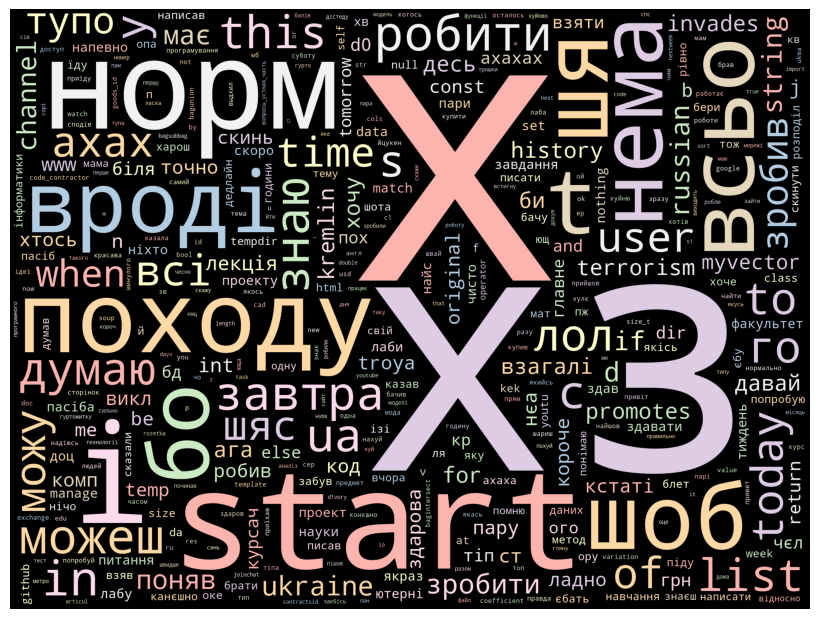

In [106]:

stop_words =  set(get_stop_words('russian')) | set(get_stop_words('ukrainian')) | {
    'http', 'шо', 'https', 'бля', 'блять', 'хуйня', 'ніхуя', 'нє', 'ок', 'ше', 'шось', 'the', 'якшо', 'com', 'х', '', '', '', '', '', '', '', '', '', '', ''
}


all_words = ""
for message in sent_by_me_df['message'].tolist():
    if not isinstance(message, str):
        continue
    text = re.sub(r'\W+', ' ', message).replace("\n", "").lower()
    words = nltk.word_tokenize(text)
    without_stop_words = [word for word in words if not word in stop_words]
    for word in without_stop_words:
        all_words += f'{word} '
wordcloud = WordCloud(
    width=2000,
    height=1500,
    random_state=1,
    background_color="black",
    margin=20,
    colormap="Pastel1",
    collocations=False,
    max_words=400,
    stopwords=stop_words,
).generate(all_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### 2. My average response time

In [114]:
to_me_and_from_me = df.loc[ (df['to_id'] == MY_TELEGRAM_ID)]
to_me_and_from_me

,id,date,from_id,to_id,fwd_from,message,type,duration,dialog_id
882724,66108,2021-03-28 16:02:02+00:00,NaN,331389579,NaN,2 замовлення відхилене і 1 дійсне. Це 1 964 208,text,NaN,1113323042
882726,66106,2021-03-28 15:51:57+00:00,NaN,331389579,NaN,"Доброго дня, чим можу допомогти?",text,NaN,1113323042
882727,66105,2021-03-28 15:51:54+00:00,NaN,331389579,NaN,Денис присоединился к чату,text,NaN,1113323042
882729,91343,2022-02-25 21:00:36+00:00,NaN,331389579,NaN,Сработал СТ по сделке #nlmk_l_8,text,NaN,1166092293
882730,90644,2022-01-21 21:49:08+00:00,NaN,331389579,NaN,Уточнение по #vtbr_l_4 - сделка уже была закры...,text,NaN,1166092293
...,...,...,...,...,...,...,...,...,...
917495,41932,2020-04-30 17:31:35+00:00,NaN,331389579,NaN,скільки,text,NaN,425082023
917496,41931,2020-04-30 17:31:28+00:00,NaN,331389579,NaN,ну шо,text,NaN,425082023
917498,41591,2020-04-29 07:35:50+00:00,NaN,331389579,"MessageFwdHeader(date=datetime.datetime(2020, ...",Щиро дякую всіх студентів за старання та належ...,text,NaN,425082023
917500,41198,2020-04-23 15:33:47+00:00,NaN,331389579,NaN,👠,sticker,NaN,425082023
